In [1]:
%cd '/content/drive/MyDrive/TrainingData'

[Errno 2] No such file or directory: '/content/drive/MyDrive/TrainingData'
/home/gmvincen/class_work/ece_542/terrain-identification


In [58]:
import os
import glob
import time
import numpy as np
import pandas as pd

import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
class_names = {0: "Solid Ground",
               1: "Downstairs",
               2: "Upstairs",
               3: "Grass",
}

In [4]:
def downsample(x, y, win_len=0.1):
    agg_x = pd.DataFrame()
    for center in y['time']:
        window_start = center - win_len/2
        window_end = center + win_len/2
        windowed_signal = x[(x["time"] > window_start) & (x["time"] < window_end)][['accr_x', 'accr_y','accr_z','gyr_x','gyr_y','gyr_z']]
        aggregate_data = windowed_signal.mean().to_frame().T
        aggregate_data['time'] =  center
        agg_x = pd.concat([agg_x, aggregate_data], axis=0)
    
    return pd.concat([agg_x.reset_index(drop=True), y['label']], axis=1)

In [5]:
# data_root = ''
# X_TIME = 'subject_{}_{}__x_time.csv'
# X_DATA = 'subject_{}_{}__x.csv'

# Y_TIME = 'subject_{}_{}__y_time.csv'
# Y_DATA = 'subject_{}_{}__y.csv'

In [6]:
# files_x_data = sorted(glob.glob(data_root+X_DATA.format('*', '*')))
# files_x_time = sorted(glob.glob(data_root+X_TIME.format('*', '*')))

# files_y_data = sorted(glob.glob(data_root+Y_DATA.format('*', '*')))
# files_y_time = sorted(glob.glob(data_root+Y_TIME.format('*', '*')))

In [7]:
# merged_data = pd.DataFrame()

In [8]:
# for i in range(len(files_x_data)):
#     y_data = pd.read_csv(files_y_data[i], names=['label'])
#     y_time = pd.read_csv(files_y_time[i], names=['time'])

#     x_data = pd.read_csv(files_x_data[i], names=['accr_x', 'accr_y','accr_z','gyr_x','gyr_y','gyr_z'])
#     x_time = pd.read_csv(files_x_time[i], names=['time'])

#     x_data = pd.concat([x_data, x_time], axis=1)
#     y_data = pd.concat([y_data, y_time], axis=1)
     
#     dwn_smp = downsample(x_data, y_data)
    
#     merged_data = pd.concat([merged_data, dwn_smp], axis=0).reset_index(drop=True)

In [9]:
# merged_data.to_csv('merged_data.csv', index=False)

In [13]:
merged_data = pd.read_csv('data/merged_data.csv')
X = merged_data[['accr_x','accr_y','accr_z','gyr_x','gyr_y','gyr_z','time']]
Y = merged_data[['label']]

### SMOTE Over-Sampling

In [14]:
oversample = SMOTE()
Xtrain, Ytrain = oversample.fit_resample(X, Y)

In [15]:
print(Y.value_counts(normalize=True),'\n')
print(Ytrain.value_counts(normalize=True))
print(len(Y))
print(len(Ytrain))

label
0        0.750517
3        0.153867
2        0.054461
1        0.041155
dtype: float64 

label
0        0.25
1        0.25
2        0.25
3        0.25
dtype: float64
335413
1006932


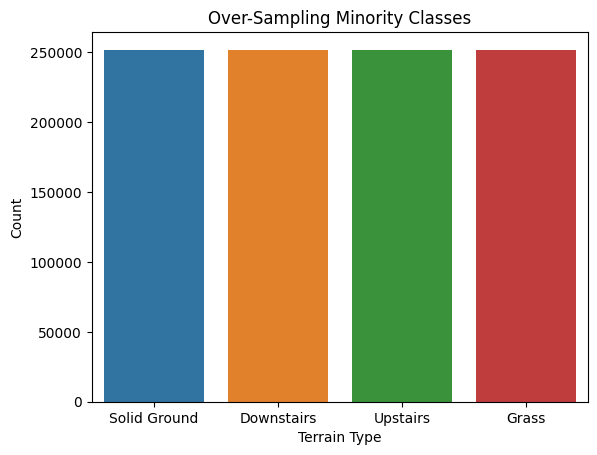

In [55]:
sns.countplot(x=Ytrain.values.ravel())
plt.rcParams.update({"font.size": 10, 
                     "lines.markersize": 6.0, 
                     "ytick.labelsize": 10,
                     "xtick.labelsize": 10})
plt.xticks(ticks=list(class_names.keys()), labels=list(class_names.values()))
plt.title("Over-Sampling Minority Classes")
plt.xlabel("Terrain Type")
plt.ylabel("Count")
plt.show()

## Random-Forest Fitting

In [41]:
X_train, X_valid, Y_train, Y_valid = train_test_split(Xtrain, Ytrain, test_size=0.2)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train.values.ravel())

Y_pred = rf.predict(X_valid)

In [42]:
valid_accuracy = accuracy_score(Y_valid, Y_pred)
print("Validation Accuracy:", valid_accuracy)

Validation Accuracy: 0.9112306156802574


In [43]:
Y_pred_train = rf.predict(X_train)
train_accuracy = accuracy_score(Y_train, Y_pred_train)
print("Train Accuracy:", train_accuracy)

Train Accuracy: 0.9999987586044231


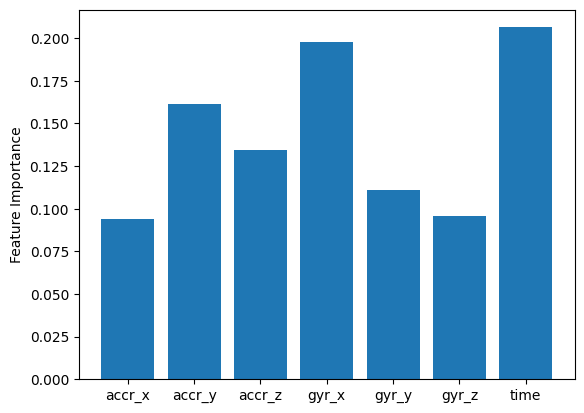

In [56]:
importances = rf.feature_importances_
feature_names = {0:'accr_x', 1:'accr_y', 2:'accr_z', 3:'gyr_x', 4:'gyr_y', 5:'gyr_z', 6:'time'}
plt.bar(range(len(importances)), importances)
plt.xticks(ticks = list(feature_names.keys()), labels=list(feature_names.values()))
plt.ylabel("Feature Importance")
plt.show()

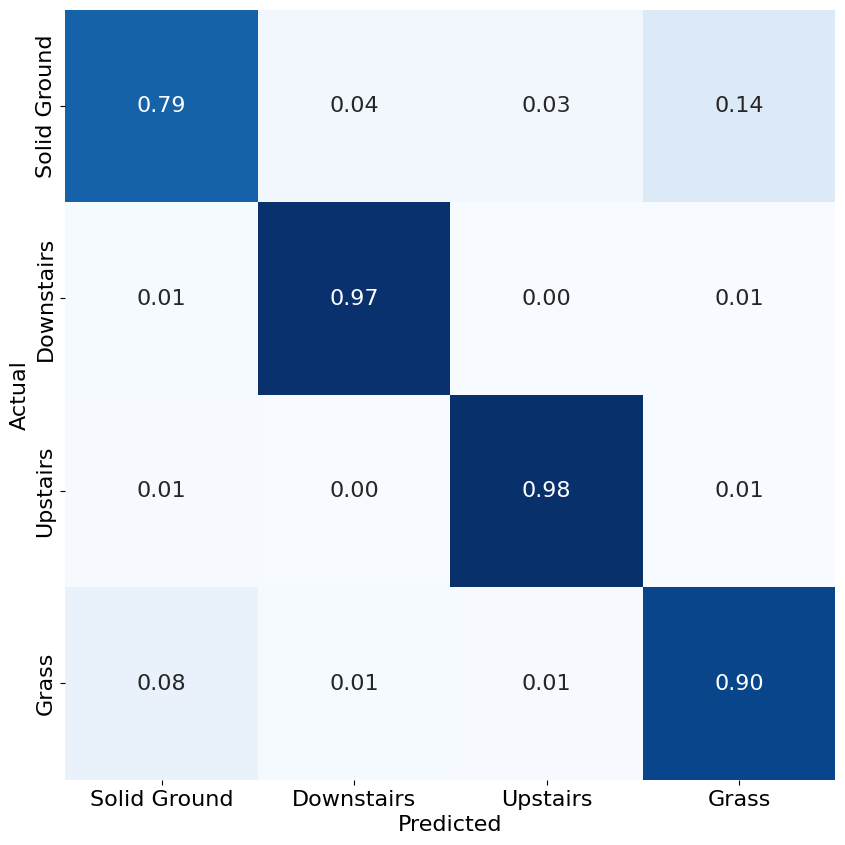

In [46]:
cm = confusion_matrix(Y_valid, Y_pred, normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({"font.size": 16})
sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    ax=ax,
    square=True,
    cbar=False,
    robust=True,
    xticklabels=list(class_names.values()),
    yticklabels=list(class_names.values()),
)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.show()

In [47]:
# precision = precision_score(Y_valid, Y_pred)
# print("Precision:", precision)
# recall = recall_score(Y_valid, Y_pred)
# print("Recall:", recall)

score = f1_score(Y_valid, Y_pred, average="macro")
print("Macro F1-Score: ", score)

score = f1_score(Y_valid, Y_pred, average="micro")
print("Micro F1-Score: ", score)

score = f1_score(Y_valid, Y_pred, average="weighted")
print("Weighted F1-Score: ", score)

Macro F1-Score:  0.910160594145286
Micro F1-Score:  0.9112306156802574
Weighted F1-Score:  0.9100681518247073


### Testing Different Number of Estimators in the Random-Forest Model

In [59]:
estimators = [10, 25, 50, 75, 100, 150, 200]

train_scores = []
val_scores = []
val_acc = []

for estimator in estimators:
    start = time.time()
    print(f"Using {estimator} Estimators")
    rf = RandomForestClassifier(n_estimators=estimator, random_state=42)
    rf.fit(X_train, Y_train.values.ravel())

    train_pred = rf.predict(X_train)
    train_f1 = f1_score(Y_train, train_pred, average='macro')
    train_scores.append(train_f1)

    val_pred = rf.predict(X_valid)
    val_f1 = f1_score(Y_valid, val_pred, average='macro')
    val_scores.append(val_f1)
    
    acc = accuracy_score(Y_valid, val_pred)
    val_acc.append(acc)
    end = time.time()
    print(f"Train F1: {train_f1} \t Val F1: {val_f1} \t Val Accuracy: {acc} \t Train Time: {end-start} secs")

Using 10 Estimators
Train F1: 0.9969498922857375 	 Val F1: 0.8891546982785411 	 Val Accuracy: 0.8899978648075596 \ Train Time: 31.518056869506836 secs
Using 25 Estimators
Train F1: 0.9997044547441228 	 Val F1: 0.903674587132623 	 Val Accuracy: 0.9047257270826816 \ Train Time: 77.97237086296082 secs
Using 50 Estimators
Train F1: 0.9999577782377937 	 Val F1: 0.9086202632602565 	 Val Accuracy: 0.9096763942061802 \ Train Time: 157.8194558620453 secs
Using 75 Estimators
Train F1: 0.9999913065979787 	 Val F1: 0.9092716703191347 	 Val Accuracy: 0.9103616420126424 \ Train Time: 233.36119556427002 secs
Using 100 Estimators
Train F1: 0.9999987577020848 	 Val F1: 0.910160594145286 	 Val Accuracy: 0.9112306156802574 \ Train Time: 311.96058464050293 secs
Using 150 Estimators
Train F1: 1.0 	 Val F1: 0.9111979404870949 	 Val Accuracy: 0.9122733840813956 \ Train Time: 466.61042165756226 secs
Using 200 Estimators
Train F1: 1.0 	 Val F1: 0.9114586221281591 	 Val Accuracy: 0.9125365589635875 \ Train Time

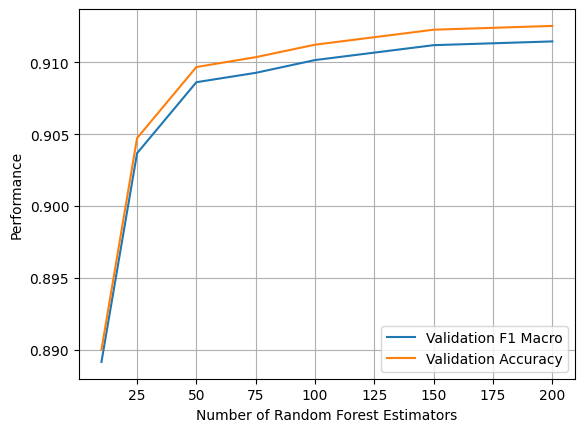

In [60]:
#plt.plot(estimators, train_scores, label='Training F1 Macro')
plt.plot(estimators, val_scores, label='Validation F1 Macro')
plt.plot(estimators, val_acc, label='Validation Accuracy')
plt.xlabel('Number of Random Forest Estimators')
plt.ylabel('Performance')
#plt.title('Random forest learning curve')
plt.legend()
plt.grid()
plt.show()

## Down-Sampling

In [ ]:
%cd '/content/drive/MyDrive/TestData'

/content/drive/MyDrive/TestData


In [ ]:
data_root = ''
X_TIME = 'subject_012_01__x_time.csv'
X_DATA = 'subject_012_01__x.csv'

Y_TIME = 'subject_012_01__y_time.csv'
Y_DATA = 'subject_012_01__y.csv'

In [ ]:
files_x_data = sorted(glob.glob(data_root+X_DATA.format('*', '*')))
files_x_time = sorted(glob.glob(data_root+X_TIME.format('*', '*')))
files_y_time = sorted(glob.glob(data_root+Y_TIME.format('*', '*')))

In [ ]:
def test_downsample(x, y, win_len=0.1):
    agg_x = pd.DataFrame()
    for center in y['time']:
        window_start = center - win_len/2
        window_end = center + win_len/2
        windowed_signal = x[(x["time"] > window_start) & (x["time"] < window_end)][['accr_x', 'accr_y','accr_z','gyr_x','gyr_y','gyr_z']]
        aggregate_data = windowed_signal.mean().to_frame().T
        aggregate_data['time'] =  center
        agg_x = pd.concat([agg_x, aggregate_data], axis=0)
    return agg_x

In [ ]:
for i in range(len(files_x_data)):
    
    y_time = pd.read_csv(files_y_time[i], names=['time'])

    x_data = pd.read_csv(files_x_data[i], names=['accr_x', 'accr_y','accr_z','gyr_x','gyr_y','gyr_z'])
    x_time = pd.read_csv(files_x_time[i], names=['time'])

    x_data = pd.concat([x_data, x_time], axis=1)
         
    dwn_smp = test_downsample(x_data, y_time)
    
    merged_data = pd.concat([dwn_smp], axis=0).reset_index(drop=True)

    Y_pred_test = rf.predict(merged_data)
    
    pd.DataFrame(Y_pred_test).to_csv(data_root+Y_DATA, index=False, header=False)